# Step 1:Importing the Necessary Libraries

In this Section we are importing required libraries for data manipulation,for visualisation and building the model

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error

# Step 2: Loading And Visualizing Data

*In this step, I load the Ethereum historical data (from 2018 to 2024) and visualize the closing prices to understand how the price has fluctuated over time.*

In [62]:
file_path='/content/drive/MyDrive/Colab Notebooks/ethereum_daily_data_2018_2024.csv'
data=pd.read_csv(file_path)
data

,time,Open,High,Low,Close,Volume
0,2018-01-01,741.69,766.49,718.90,757.22,910875.63
1,2018-01-02,756.17,882.61,756.17,861.97,1123318.86
2,2018-01-03,861.97,951.70,847.90,941.10,871172.13
3,2018-01-04,941.00,997.44,901.03,944.83,822844.78
4,2018-01-05,944.50,1165.81,926.75,963.88,1682729.53
...,...,...,...,...,...,...
2457,2024-09-22,2613.27,2632.42,2525.50,2581.43,433318.91
2458,2024-09-23,2581.43,2703.72,2540.14,2647.17,797788.43
2459,2024-09-24,2647.17,2671.47,2591.67,2653.41,564932.40
2460,2024-09-25,2653.41,2673.98,2554.44,2579.69,458195.34


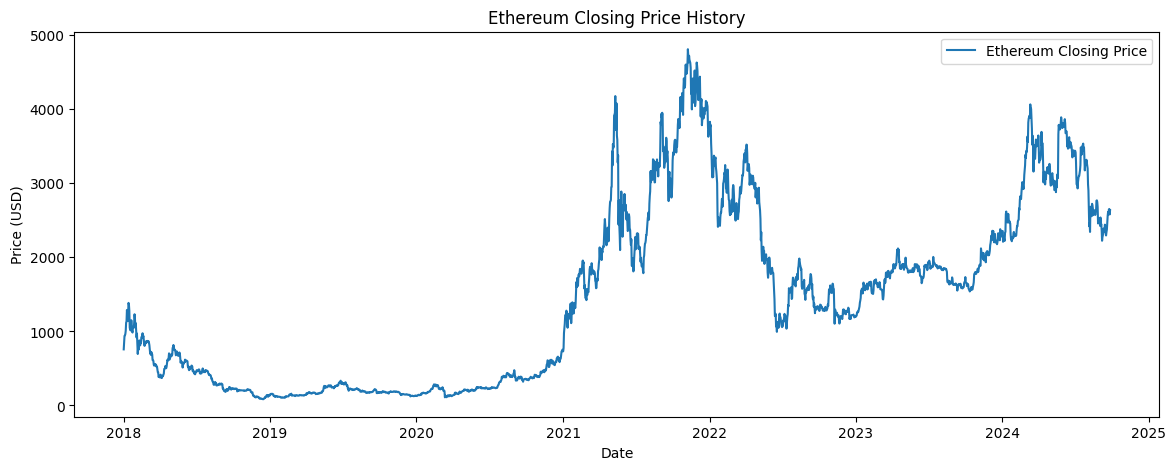

In [63]:

# Convert 'time' to datetime format
data['time'] = pd.to_datetime(data['time'])

# Set 'time' as index
data.set_index('time', inplace=True)

# Visualizing the Ethereum closing price
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Ethereum Closing Price')
plt.title('Ethereum Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()



# Step 3: Data Preprocessing

To prepare the data for the LSTM model, I scale the closing price values to a range of 0 to 1 using MinMaxScaler. This is crucial because LSTM models perform better when the input data is normalized.

Sequence Creation : I create sequences of 60 days for training the LSTM model. Each sequence will serve as the input for predicting the next day’s price.

Train-Test Split : I split the data into training and testing sets, using 80% of the data for training and 20% for testing.

In [81]:
# 2. Data Preprocessing

# Scale the 'Close' prices for LSTM input (range 0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Creating a function to split the data into sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)



# Define the sequence length (e.g., 60 days)
sequence_length = 60

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create training sequences and labels
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Shuffle the training data with a fixed random state
random_state = 42
np.random.seed(random_state)
shuffle_indices = np.random.permutation(len(X_train))

X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]


# Step 4: Building the LSTM Model

Here, I constructed an LSTM model with two LSTM layers and dropout to prevent overfitting.

LSTM Layers : These layers capture long-term dependencies in the time series data.

Dropout: Regularization to reduce the chance of overfitting.

Dense Layers : Fully connected layers to output a single price prediction.

In [66]:
# Building the LSTM Model

# Initialize the LSTM model
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(Input(shape=(X_train.shape[1], 1)))  # Defining the input shape explicitly
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layers for output
model.add(Dense(units=25))
model.add(Dense(units=1))  # Final output layer

# Step 5: Compiling and Training the Model

I compiled the model using the Adam optimizer and mean squared error as the loss function, which is a common choice for regression tasks like price prediction.

Training : I trained the model over 60 epochs using a  default batch size. The training and validation loss is tracked to ensure the model is learning effectively.

In [74]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model (80 epochs,  default batch size )
history = model.fit(X_train, y_train, epochs=70, validation_data=(X_test, y_test))


Epoch 1/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0011 - val_loss: 5.1669e-04
Epoch 2/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - val_loss: 7.8466e-04
Epoch 3/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.6767e-04 - val_loss: 5.8679e-04
Epoch 4/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.6296e-04 - val_loss: 4.4419e-04
Epoch 5/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 4.4635e-04
Epoch 6/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 8.0800e-04
Epoch 7/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4121e-04 - val_loss: 5.8664e-04
Epoch 8/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.9281e-04 - val_loss: 4.2979e-04
Epoch 9/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 8.3623e-04
Epoch 10/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.9504e-04 - val_loss: 9.6289e-04
Epoch 11/70
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 4.0965e-04
Epoch 

# Step 6: Model Evaluation

After training, I evaluate the model by making predictions on the test set. I then calculate the Mean Squared Error (MSE) to measure the model’s performance. A lower MSE indicates better prediction accuracy.

Inverse Scaling : I convert the scaled predictions and actual test data back to their original scale for interpretation.

MSE Calculation : The model’s performance is measured based on how close its predictions are to the actual prices.

In [75]:
# 6. Model Evaluation

# Predicting on the test data
predictions = model.predict(X_test)

# Inverse scaling the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

# Inverse scaling the actual test values
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_test_scaled, predictions)
print(f"Mean Squared Error: {mse}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Mean Squared Error: 7876.645341157348


# Step 7: Predicting Future Prices

Using the last 60 days of historical data, I predict Ethereum’s future price for the next day. The predicted price is scaled back to the original range for readability.

In [76]:
# 7. Predicting Future Ethereum Price

# Get the last 60 days of data from the dataset
last_60_days = data['Close'][-sequence_length:].values.reshape(-1, 1)

# Scale the last 60 days data
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list to hold the scaled sequence
X_predict = []
X_predict.append(last_60_days_scaled)

# Convert the list to a numpy array and reshape for LSTM input
X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

# Predict the future price
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Ethereum Price: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Ethereum Price: 2644.01513671875


# Step 8: Displaying Key Metrics

I summarized important metrics such as the total number of data points, the MSE, and the first and last actual and predicted prices in a DataFrame for easy interpretation.

In [77]:
# Create a DataFrame for results
results_df = pd.DataFrame({
    'Metric': ['Total Data Points', 'Training Data Points', 'Testing Data Points',
               'Mean Squared Error (MSE)', 'First Actual Price', 'First Predicted Price',
               'Last Actual Price', 'Last Predicted Price', 'Predicted Future Price'],
    'Value': [len(data), len(X_train), len(X_test),
              mse, y_test_scaled[0][0], predictions[0][0],
              y_test_scaled[-1][0], predictions[-1][0], predicted_price[0][0]]
})

# Markdown
print(results_df.to_markdown())

|    | Metric                   |   Value |
|---:|:-------------------------|--------:|
|  0 | Total Data Points        | 2462    |
|  1 | Training Data Points     | 1909    |
|  2 | Testing Data Points      |  433    |
|  3 | Mean Squared Error (MSE) | 7876.65 |
|  4 | First Actual Price       | 1866.58 |
|  5 | First Predicted Price    | 1904.53 |
|  6 | Last Actual Price        | 2636.51 |
|  7 | Last Predicted Price     | 2621.54 |
|  8 | Predicted Future Price   | 2644.02 |


# Step 9: Visualization

To visually compare the model’s performance, I plot the actual vs predicted prices for the test set. This gives a clearer picture of how closely the model’s predictions align with the actual prices.

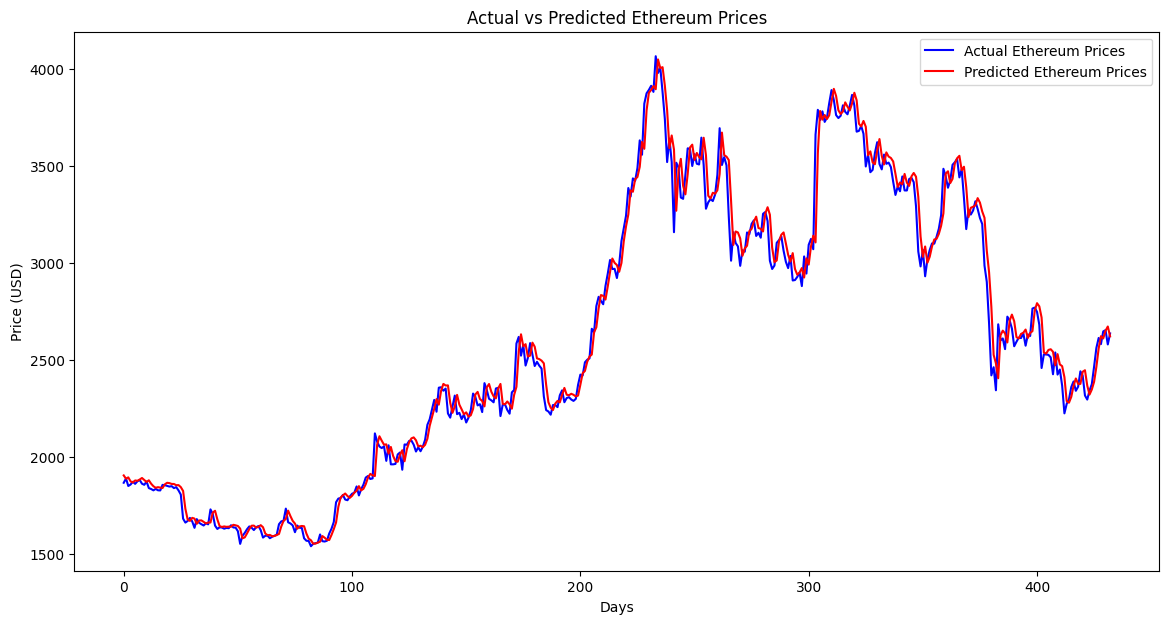

In [78]:
# Plotting actual vs predicted prices

plt.figure(figsize=(14, 7))

# actual
plt.plot(y_test_scaled, label='Actual Ethereum Prices', color='blue')

# predicted prices
plt.plot(predictions, label='Predicted Ethereum Prices', color='red')

# Plotting
plt.title('Actual vs Predicted Ethereum Prices')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()


plt.show()

# Step 10: Predicting the Next 60 Days

Using a recursive approach, I predict Ethereum prices for the next 60 days, appending each predicted day’s price to the sequence for subsequent predictions.

Future Predictions : I generate a list of predicted prices for the next two months and plot these predictions alongside the historical actual and predicted prices.

In [79]:
# Predicting Future Prices for the Next 60 Days

# Number of days to predict into the future
future_days = 60

# Get the last 60 days of data for starting the predictions
last_60_days = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_60_days_scaled = scaler.transform(last_60_days)

# List to store the predicted future prices
future_predictions = []

# Loop to predict the next 60 days
for i in range(future_days):
    # Create a new sequence from the last 60 days
    X_predict = []
    X_predict.append(last_60_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    # Predict the price for the next day
    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    # Store the predicted price
    future_predictions.append(predicted_price_unscaled[0, 0])

    # Update the sequence to include the predicted price
    new_scaled_data = np.append(last_60_days_scaled[1:], predicted_price, axis=0)
    last_60_days_scaled = new_scaled_data.reshape(-1, 1)

# َAdd to plott

future_dates = pd.date_range(start=data.index[-1], periods=future_days+1, freq='D')[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

# Step 11: Visualizing Future Predictions

In the final step, I add the predicted future prices to the original chart, clearly marking the future trends. This allows for a comprehensive visualization of both past model performance and future projections.

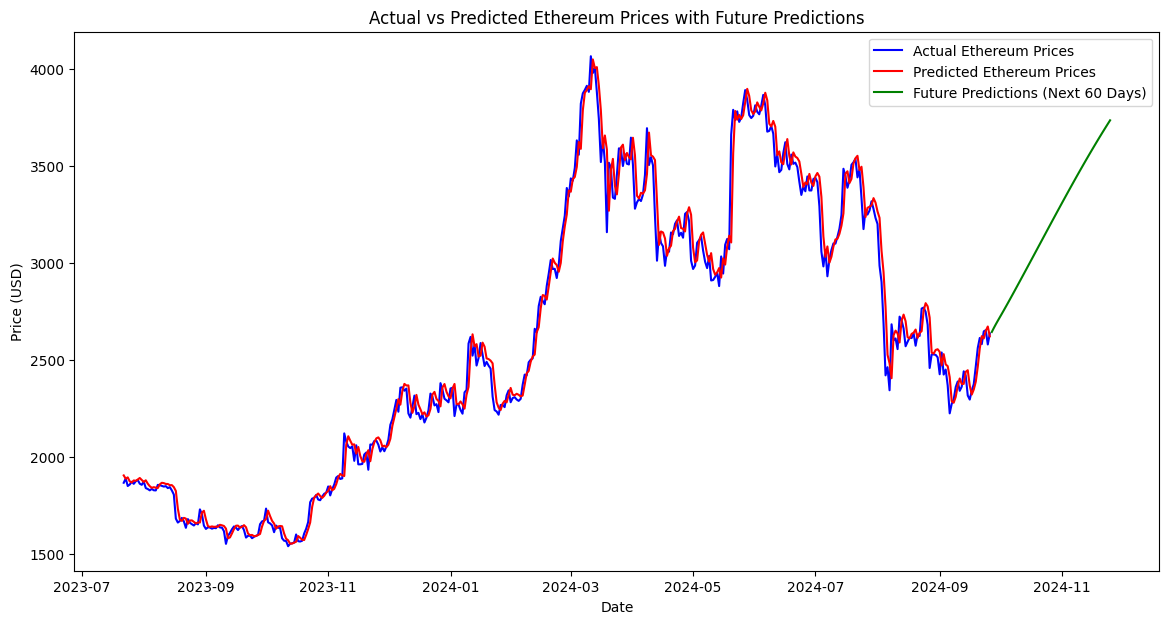

In [80]:
# Plotting future predictions alongside actual prices

plt.figure(figsize=(14, 7))

# actual prices
plt.plot(data.index[-len(y_test_scaled):], y_test_scaled, label='Actual Ethereum Prices', color='blue')

# predictions price
plt.plot(data.index[-len(y_test_scaled):], predictions, label='Predicted Ethereum Prices', color='red')

# Future Predictions (Next 60 Days)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 60 Days)', color='green')

# Plotting
plt.title('Actual vs Predicted Ethereum Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()


plt.show()

# Conclusion

In this notebook, I built and trained an LSTM model to predict Ethereum prices using historical data from 2018 to 2024. The model showed reasonable accuracy in capturing the price trends, both for the test data and future predictions. Overall, this approach demonstrates how deep learning models like LSTM can be leveraged for time-series forecasting in financial markets.